In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from scipy.stats import linregress
import matplotlib.colors as mcolors
from scipy.stats import norm

# Context

Labeling is a critical step in machine learning as it defines the learning objective. The way labels are constructed determines what the model is being trained to predict. For example, we may attempt to predict:

- The sign of tomorrow’s return.
- The sign of the next 3% move (regardless of how long it takes).

These are fundamentally different tasks, and failing to predict one does not imply we cannot predict the other.

## Fixed-Horizon Labeling

A common method in financial ML is Fixed-Horizon Labeling, which evaluates return over a fixed future time interval (e.g., one day). The label is assigned based on whether the return breaches a specified threshold $\tau$:

$$
y_i =
\begin{cases}
-1 & \text{if } r_{t_i} < -\tau \\
\;\;0 & \text{if } |r_{t_i}| \leq \tau \\
\;\;1 & \text{if } r_{t_i} > \tau
\end{cases}
$$

where the return is defined as:

$$
r_{t_i} = \frac{\text{price}_{t_{i+1}}}{\text{price}_{t_i}} - 1
$$

This method is sub-optimal, as:
- It is affected by heteroskedasticity (e.g., intraday volatility varies throughout the day).
- It ignores intra-interval price paths, which are crucial for modeling stop-loss and take-profit strategies.

The alternative we will expore are the Triple-Barrier Method and the Trend-Scanning Method.

## Triple-Barrier Method

This method reflects realistic trading behavior by using three exit conditions:

- Profit-taking barrier hit: label = 1  
- Stop-loss barrier hit: label = -1  
- Time limit reached without hitting barriers: label = 0 or based on final return sign

This technique incorporates path information, and better aligns with how trades are managed in practice.

## Trend-Scanning Method

This method identifies statistically significant trends by:

- Fitting linear regressions over several forward-looking windows.
- Computing t-statistics for trend coefficients.
- Selecting the window with the most significant trend (highest $t-value$).

Each point is labeled based on whether it lies in an uptrend (1), downtrend (-1), or no trend (0).

With this techique we don't need to define fixed horizons or thresholds. It is also well-suited for both classification and regression tasks.

## Meta-Labeling

Meta-labeling introduces a secondary model that evaluates the predictions of a primary model.

- The primary model predicts trade direction (the label).
- The secondary model predicts the probability whether the trade will succeed or fail ($p_{\text{success}}$).

Given $p_{\text{success}}$, we can:

- Improve precision at the cost of some recall.
- Adjust position size dynamically using measures like the expected Sharpe ratio.

This secondary model helps reduce exposure to false positives, making the trading strategy more robust.

In [2]:
# We choose candles for Google 
df_all_candles = pd.read_csv('stocks_candles.csv')
df_candles = df_all_candles[df_all_candles['Symbol']=='GOOG'].copy()
df_candles['Date'] = pd.to_datetime(df_candles['Date'], utc=True)
df_candles = df_candles[['Date','Open', 'High', 'Low', 'Close', 'Volume']]

df_candles.head()

,Date,Open,High,Low,Close,Volume
9184,2020-01-02 05:00:00+00:00,66.761282,68.084512,66.761282,68.046196,28132000
9185,2020-01-03 05:00:00+00:00,67.075290,68.301485,66.960037,67.712273,23728000
9186,2020-01-06 05:00:00+00:00,67.181792,69.495829,67.181792,69.381874,34646000
9187,2020-01-07 05:00:00+00:00,69.567504,69.818809,69.191280,69.338585,30054000
9188,2020-01-08 05:00:00+00:00,69.275865,70.246275,69.214161,69.884987,30560000


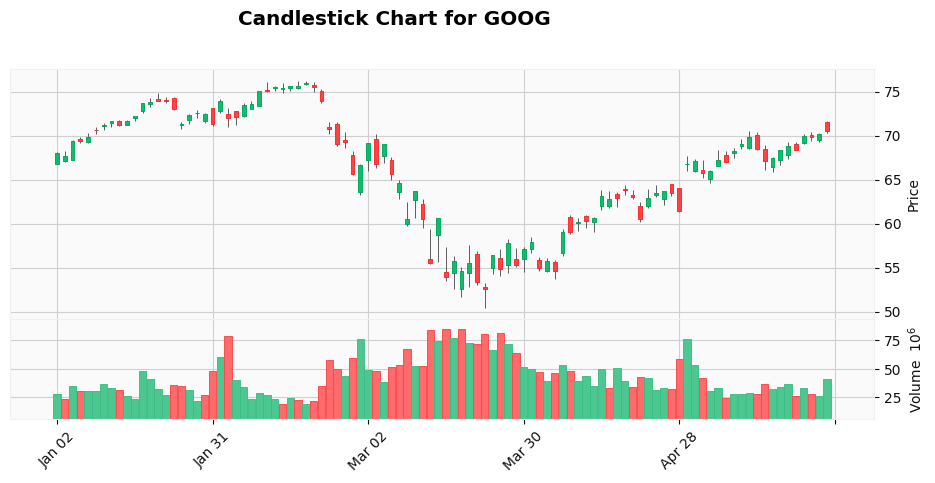

In [3]:
mpf.plot(df_candles.set_index('Date').iloc[:100], 
         figsize=(12, 5), 
         type='candle', 
         style='yahoo', 
         volume=True,
         title='Candlestick Chart for GOOG')

## Triple barrier labeling

In [4]:
def label_triple_barrier(df_candles, date_start, time_barrier_minutes,
                          upper_barrier, lower_barrier, make_low_first=True,
                          time_barrier_as_return=False):

    '''
    For a given date_start, we assign the return (r) and label based on:
    - the data about candles (df_candles)
    - the time barrier expressed in minutes
    - the lower and upper barriers (defined on returns from the trade date)

    There is also a make_low_first flag, that defines for each candle in df_canldes, 
    if the low_price appeared before the high_price (1) or the other war round (0).
    '''
    
    # Step 1: Calculate end time for time barrier
    date_time_barrier = date_start + pd.to_timedelta(time_barrier_minutes, unit='m')

    # Step 2: Find subset using searchsorted (fast range slicing)
    start_idx = df_candles['Date'].searchsorted(date_start)
    end_idx = df_candles['Date'].searchsorted(date_time_barrier, side='right')
    df_subset = df_candles.iloc[start_idx:end_idx]

    if df_subset.shape[0] <= 1:
        return np.nan, np.nan  # Not enough data

    df_subset = df_subset.iloc[:-1]  # Remove last candle (it exceeds the horizon)

    # Step 3: Prepare OHLC and LowFirst logic
    ohlc = df_subset[['Open', 'High', 'Low', 'Close']].values
    if 'LowFirst' not in df_subset.columns:
        if make_low_first:
            df_subset['LowFirst'] = 1
        else:
            df_subset['LowFirst'] = 0
    low_first = df_subset['LowFirst'].values == 1

    # Rearranged price series
    ordered_prices = np.where(
        low_first[:, None],
        ohlc[:, [0, 2, 1, 3]],  # If LowFirst
        ohlc[:, [0, 1, 2, 3]]   # If HighFirst
    ).reshape(-1)

    # Normalize returns
    normalized_returns = ordered_prices / ordered_prices[0] - 1

    # Expanded timestamps for each 4-part sequence
    expanded_dates = np.repeat(df_subset['Date'].values, 4) + np.tile(
        np.array([0, 1, 2, 3], dtype='timedelta64[s]'),
        len(df_subset)
    )

    # Step 4: Find which barrier is hit first
    touch_date = date_time_barrier
    label = 0

    for i in range(len(normalized_returns)):
        r = normalized_returns[i]
        if r >= upper_barrier:
            touch_date = expanded_dates[i]
            label = 1
            break
        elif r <= lower_barrier:
            touch_date = expanded_dates[i]
            label = -1
            break

    r = r.clip(lower_barrier, upper_barrier)

    # Step 5: Label correction if time barrier was reached
    if touch_date == date_time_barrier and time_barrier_as_return:
        if r >=0:
            label = 1
        else:
            label = -1

    return r, label


# Testing the function

time_barrier_minutes = 60*24*10 # 5 days
upper_barrier = 0.05 # 5%
lower_barrier = -0.05 # -5%

date_start = pd.to_datetime('2020-01-02 05:00:00+00:00', utc='True') # Time of the trade

label_triple_barrier(df_candles, date_start, 
                     time_barrier_minutes,upper_barrier, lower_barrier, 
                     make_low_first=True, time_barrier_as_return=False)

(0.05, 1)

In [5]:
# Calculating the labels for the whole dataset

df_candles_labeled = df_candles.copy()

df_candles_labeled[['return','label']] = \
    df_candles.apply(lambda row: pd.Series(label_triple_barrier(df_candles, row['Date'], 
                                                      time_barrier_minutes, upper_barrier, lower_barrier, 
                                                      make_low_first=True,time_barrier_as_return=False)[:2]), axis=1)

df_candles_labeled

,Date,Open,High,Low,Close,Volume,return,label
9184,2020-01-02 05:00:00+00:00,66.761282,68.084512,66.761282,68.046196,28132000,0.050000,1.0
9185,2020-01-03 05:00:00+00:00,67.075290,68.301485,66.960037,67.712273,23728000,0.050000,1.0
9186,2020-01-06 05:00:00+00:00,67.181792,69.495829,67.181792,69.381874,34646000,0.050000,1.0
9187,2020-01-07 05:00:00+00:00,69.567504,69.818809,69.191280,69.338585,30054000,0.038457,0.0
9188,2020-01-08 05:00:00+00:00,69.275865,70.246275,69.214161,69.884987,30560000,0.042828,0.0
...,...,...,...,...,...,...,...,...
10491,2025-03-17 04:00:00+00:00,167.324997,168.460007,165.809998,166.570007,17839100,-0.050000,-1.0
10492,2025-03-18 04:00:00+00:00,165.960007,166.440002,158.800003,162.669998,24616800,-0.005483,0.0
10493,2025-03-19 04:00:00+00:00,163.914993,168.132996,163.050003,166.279999,24955700,0.006924,0.0
10494,2025-03-20 04:00:00+00:00,163.824997,167.029999,163.139999,165.050003,19981500,0.007478,0.0


## Trend labeling

In [6]:
def label_linear_trend(df, date_start, minutes_min, minutes_max, min_tval):

    '''
    For forward looking periods between minutes_min and minutes_max, choose the
    linear trend with the highest t-value, and assign label:
    0 if abs(t-value) < min_tval
    +-1 for growing / decreasing trends 
    '''

    min_date = date_start + pd.Timedelta(minutes=minutes_min)
    max_date = date_start + pd.Timedelta(minutes=minutes_max)

    mask = (df['Date'] >= date_start) & (df['Date'] <= max_date)
    subset = df[mask].reset_index(drop=True)

    if subset.shape[0] < 2:
        return np.nan, np.nan, np.nan, np.nan

    orig_x = (subset['Date'] - subset['Date'].iloc[0]).dt.total_seconds().values
    orig_y = subset['Close'].values

    min_date_seconds = (min_date - subset['Date'].iloc[0]).total_seconds()

    minutes_fin = np.nan
    slope_fin = np.nan
    t_stat_fin = np.nan
    label_fin = np.nan

    for i in reversed(range(2, len(orig_x) + 1)):
        x = orig_x[:i]
        y = orig_y[:i]

        if x[-1] < min_date_seconds:
            break

        slope, _, _, _, std_err = linregress(x, y)
        t_stat = slope / std_err if std_err != 0 else np.nan

        if abs(t_stat) > abs(t_stat_fin) or np.isnan(t_stat_fin):
            minutes_fin = x[-1] / 60
            slope_fin = slope
            t_stat_fin = t_stat
            if abs(t_stat) > min_tval:
                label_fin = np.sign(t_stat)
            else:
                label_fin = 0

    return minutes_fin, slope_fin, t_stat_fin, label_fin


date_start = pd.to_datetime('2020-01-02 05:00:00+00:00', utc='True')
minutes_min, minutes_max = 5*60*24, 10*60*24
min_tval = 1

label_linear_trend(df_candles, date_start, minutes_min, minutes_max, min_tval)

(11520.0, 4.739753602526149e-06, 9.189788164324623, 1.0)

In [7]:
df_candles_labeled = df_candles.copy()

df_candles_labeled[['tval', 'label']] = df_candles.apply(
    lambda row: pd.Series(label_linear_trend(df_candles, row['Date'], minutes_min, minutes_max, min_tval)[2:4]),
    axis=1
)

df_candles_labeled

,Date,Open,High,Low,Close,Volume,tval,label
9184,2020-01-02 05:00:00+00:00,66.761282,68.084512,66.761282,68.046196,28132000,9.189788,1.0
9185,2020-01-03 05:00:00+00:00,67.075290,68.301485,66.960037,67.712273,23728000,11.956439,1.0
9186,2020-01-06 05:00:00+00:00,67.181792,69.495829,67.181792,69.381874,34646000,7.289000,1.0
9187,2020-01-07 05:00:00+00:00,69.567504,69.818809,69.191280,69.338585,30054000,6.031694,1.0
9188,2020-01-08 05:00:00+00:00,69.275865,70.246275,69.214161,69.884987,30560000,4.618401,1.0
...,...,...,...,...,...,...,...,...
10491,2025-03-17 04:00:00+00:00,167.324997,168.460007,165.809998,166.570007,17839100,NaN,NaN
10492,2025-03-18 04:00:00+00:00,165.960007,166.440002,158.800003,162.669998,24616800,NaN,NaN
10493,2025-03-19 04:00:00+00:00,163.914993,168.132996,163.050003,166.279999,24955700,NaN,NaN
10494,2025-03-20 04:00:00+00:00,163.824997,167.029999,163.139999,165.050003,19981500,NaN,NaN


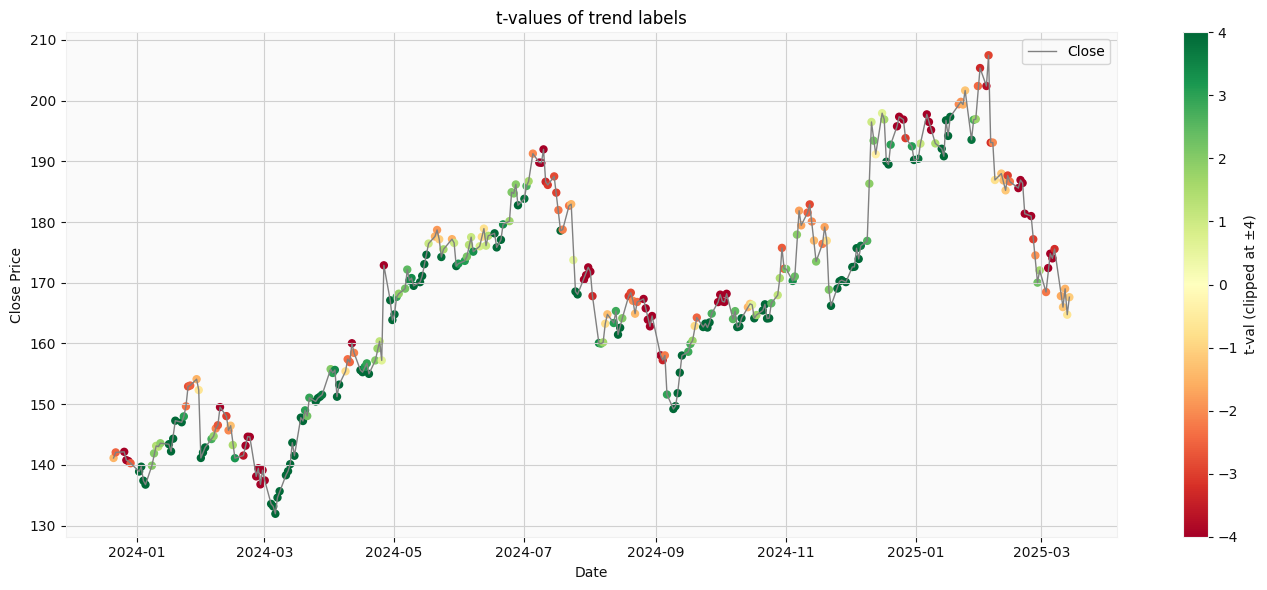

In [8]:
# Plotting the labels

# Copy and clean
df = df_candles_labeled.iloc[1000:].copy()
df = df[df['tval'].notna()]

tval_clip = 4 # Values above 4 and above will be shown with the same colour

tval_clipped = df['tval'].clip(-tval_clip, tval_clip)
norm_x = plt.Normalize(vmin=-tval_clip, vmax=tval_clip)
cmap = plt.cm.RdYlGn  # Colormap of red - yellow - green

# Plotting
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df['Date'], df['Close'], color='grey', linewidth=1, label='Close')
sc = ax.scatter(df['Date'], df['Close'], c=tval_clipped, cmap=cmap, norm=norm_x, s=25)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label(f't-val (clipped at ±{tval_clip})')

ax.set_title('t-values of trend labels')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


## Metalabeling

Base on the labeling described above we can decide on the side of the bet - buy or sell. But we do not know how much to bet.

Also, if our model has low precision and high recall, if we size our bets correctly, we can increase the precision of our model (by sacrificing some recall).

The steps we take to assign this are:
1. We assign labels 1 (gains) and 0 (losses) to our bets
2. We train a secondary model to predict these labels - possibly on a different set of features.
3. The trained model is used to predict probabilities of the bet being successful: $p=p_{success}$. This can be done e.g. by using a neural network with a sigmoid activation layer.

Then, if the expected profit of the opportunity is $\pi$:
- the profit of the opportunity is $\mu = p \cdot \pi + (1 - p)(- \pi) = \pi(2p - 1)$
- the variance of the opportunity is $\sigma^2 = 4\pi^2 p(1 - p)$
- the Sharpe ratio is $z = \frac{\mu}{\sigma} = \frac{p - \frac{1}{2}}{\sqrt{p(1 - p)}}$

Assuming the Sharpe ratio $z$ follows a standard Gaussian distribution, we can bet on the opportunity:

$$
b = 2\mathcal{Z}[z] - 1
$$

on the opportunity, where cumulative distribution function (CDF) of the normal distribution $\mathcal{Z}[\cdot]$

Then $b \in [-1, 1]$ is uniformly distributed and scales with the strength of the signal.

- If $z = 0$ (no edge), then $\mathcal{Z}[z] = 0.5$, and $b = 0$ (no position taken).
- As $z \to \infty$, $\mathcal{Z}[z] \to 1$, and $b \to 1$ (maximum long position).
- As $z \to -\infty$, $\mathcal{Z}[z] \to 0$, and $b \to -1$ (maximum short position).

This approach enables dynamic position sizing based on estimated probability of success.

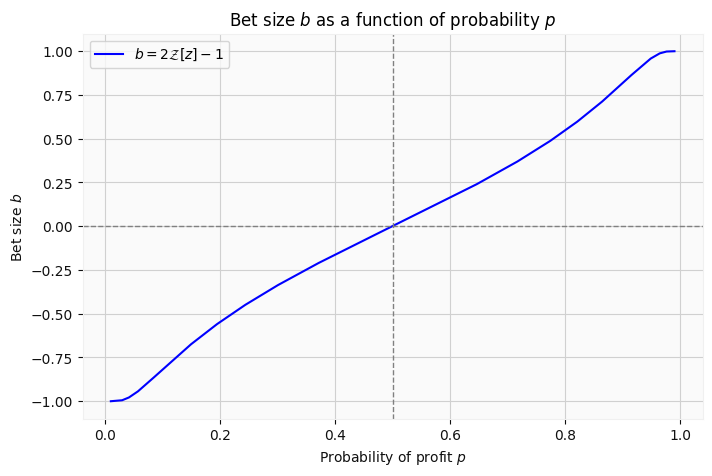

In [9]:
# Plotting the bet sizes depending on the probabilities of success

p = np.linspace(0.01, 0.99, 500) # Probabilities
z = (p - 0.5) / np.sqrt(p * (1 - p)) # Sharpe ratio
b = 2 * norm.cdf(z) - 1 # Bet size b

plt.figure(figsize=(8, 5))
plt.plot(p, b, label=r'$b = 2\mathcal{Z}[z] - 1$', color='blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0.5, color='gray', linestyle='--', linewidth=1)
plt.title('Bet size $b$ as a function of probability $p$')
plt.xlabel('Probability of profit $p$')
plt.ylabel('Bet size $b$')
plt.grid(True)
plt.legend()
plt.show()